In [ ]:
##코랩실행시 google driver mount 하기
#from google.colab import drive
#drive.mount('/content/drive')
#% cd /content/drive/My Drive/FAS


In [ ]:
!pip install pydicom
!pip install imgaug
!pip install tensorflow
!pip install tqdm

     |████████████████████████████████| 70 kB 834 kB/s eta 0:00:011


In [1]:
import pydicom as pdc
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import KFold
import glob
import pydicom as pdc
from keras.utils import to_categorical
import pydicom as pdc
import matplotlib.pyplot as plt
from IPython.display import display, Image
import tensorflow as tf
import keras
from keras.utils import to_categorical
from keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Dropout
#import tensorflow_hub as hub
from skimage import exposure
import webhook   
%pylab inline

gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[0], 'GPU') # gpus[번호바꿔서 사용 0-3번]
tf.debugging.set_log_device_placement(True)

ModuleNotFoundError: ignored

In [ ]:
#path = './metadata/'
path = '../Diagnosis_Gallbladder_Cancer/metadata/'
# Load Meta-data and preprocessing
patient_meta = pd.read_csv(path + 'patient_meta.csv')
patient_meta = patient_meta[['RANDOM_PT_NO','SEX','AGE','PHASE',"DX"]]
#patient_meta.head()

#NET, Lymphoma : Dropped (3 cases)
print("Drop:", patient_meta[(patient_meta['DX']=='lymphoma') | (patient_meta['DX']=='NET')].index)
patient_meta = patient_meta.drop(patient_meta[(patient_meta['DX']=='lymphoma') | (patient_meta['DX']=='NET')].index, axis=0)
patient_meta.reset_index(drop=True, inplace=True)

# categorical Variables(Sex, Phase)
# pd.get_dummies() 가변수 만들기
# Phase feature 는 제거
patient_meta = pd.concat([patient_meta, pd.get_dummies(patient_meta[['SEX']])], axis=1)
patient_meta = patient_meta.drop(['SEX','PHASE'], axis=1)

# Continuous Variables(Age)
age = patient_meta['AGE'].values
age_scaled = preprocessing.scale(age)
 
patient_meta['AGE_NORM'] = age_scaled
patient_meta = patient_meta.drop(['AGE'], axis = 1)

#Label Setting
# 0 : Metastasis, 56
# 1 : Hepatocelluar Carcinoma, 30
# 2 : cholangiocarcinoma, 14 --> ????    # 숫자가 의미하는 것은??
for r in range(patient_meta.shape[0]):
    if('metastasis' in patient_meta.iloc[r, 1]):
        patient_meta.iloc[r, 1] = 0
    elif('HCC' == patient_meta.iloc[r, 1]):
        patient_meta.iloc[r, 1] = 1
    elif('cholangiocarcinoma' == patient_meta.iloc[r, 1]):
        patient_meta.iloc[r, 1] = 2
    else:
        patient_meta.iloc[r, 1] = -1

patient_meta = np.array(patient_meta)   #넘파이 배열로 변환

Drop: Int64Index([42, 66, 69], dtype='int64')


In [ ]:
# 데이터 전처리 중간 점검
patient_meta

array([['SN00180816', 1, 0, 1, -0.9717086332456366],
       ['SN00361989', 1, 1, 0, -1.0655029028639413],
       ['SN00481545', 2, 1, 0, 0.9041767591204574],
       ['SN00493709', 2, 0, 1, 0.43520541102893384],
       ['SN00181638', 0, 0, 1, -0.31514874591750375],
       ['SN00222863', 0, 0, 1, 0.15382260217401975],
       ['SN00283964', 0, 0, 1, 0.997971028738762],
       ['SN00304545', 0, 1, 0, 0.9041767591204574],
       ['SN00450700', 2, 1, 0, 0.7165882198838479],
       ['SN00508749', 1, 0, 1, 0.997971028738762],
       ['SN00090078', 0, 1, 0, -0.03376593706258964],
       ['SN00369027', 0, 1, 0, -0.31514874591750375],
       ['SN00474278', 0, 1, 0, -1.44067998133716],
       ['SN00305004', 0, 1, 0, -1.3468857117188553],
       ['SN00508618', 0, 0, 1, 0.997971028738762],
       ['SN00067936', 0, 1, 0, -2.4724169471385116],
       ['SN00381399', 2, 0, 1, -0.6903258243907225],
       ['SN00407113', 1, 1, 0, 1.0917652983570667],
       ['SN00097002', 1, 0, 1, 1.3731481072119809],
   

In [ ]:
label_df = pd.read_csv('../Diagnosis_Gallbladder_Cancer/metadata/label_df.csv')
#label_df = pd.read_csv('metadata/label_df.csv')
label_df.head()

,patient_no,img_idx,mean_annotation,DX
0,SN00017916,1,0.0,0
1,SN00017916,2,0.0,0
2,SN00017916,3,0.0,0
3,SN00017916,4,0.0,0
4,SN00017916,5,0.0,0


- Z축을 5만큼 잘라서 작업
- Clahe 전처리를 시켜주고, resize는 normalize 후 처리해준다 ( resize = (64,64) )

In [ ]:
# sliding-window Proprocessing (길이가 다른 z 축데이터를 동일하게 만들어준다.)
window_size = 5
size = (64,64)
n_ct_statistics=[]
#path = './benchmark_liver_tumor/raw/'
path = '../Diagnosis_Gallbladder_Cancer/benchmark_liver_tumor/raw/'
# 10-cv Settings
kf = KFold(n_splits=5, random_state=None, shuffle=True)
for tr_list, te_list in kf.split(patient_meta):
    # Train Dataset
    X_p_tr, X_m_tr, X_i_tr, Y_tr = [], [], [], []
    for tr_idx in tr_list:
        X_i_tr_ct_list = sorted(glob.glob(path+patient_meta[tr_idx, 0]+'/*.dcm'))
        n_ct = len(X_i_tr_ct_list)
        n_ct_statistics.append(n_ct)
        # Load 3D CT Data per Patient
        ct_block = []
        dx_block = []
        maxVal = 0
        for z in range(n_ct):
            # 전처리 --> normalize --> resize  
            #ct_block.append(pdc.dcmread(X_i_tr_ct_list[z]).pixel_array)
            ct_block.append(cv2.resize(cv2.normalize(exposure.equalize_adapthist(pdc.dcmread(X_i_tr_ct_list[z]).pixel_array, clip_limit=0.03, nbins=512), dst=None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F), dsize=size))
        
        ct_block = np.array(ct_block)
         # DX 추가 부분
        dx_block = label_df.loc[label_df['patient_no']==patient_meta[tr_idx, 0],'DX']
        dx_block = np.array(dx_block)
    
        # Sliding-window Preprocess
        n_window = n_ct-window_size+1   # for 문 마지막 인덱스 설정
        X_i_tr_buffer = []
        for z in range(n_window):
            X_i_tr_buffer.append(ct_block[z:z+window_size])   # 설정된 윈도우 사이즈 만큼 사진을 가져온다.
            X_p_tr.append(patient_meta[tr_idx, 0])            # 환자 번호
            X_m_tr.append(patient_meta[tr_idx, 2:])           # 환자 메타 정보 
            maxVal = np.max(dx_block[z:z+window_size])
            Y_tr.append(maxVal)                               # DX
            
            #Y_tr.append(patient_meta[tr_idx, 1])              
        X_i_tr_buffer = np.array(X_i_tr_buffer)
        X_i_tr.extend(X_i_tr_buffer)
    X_p_tr, X_m_tr, X_i_tr, Y_tr = np.array(X_p_tr), np.array(X_m_tr), np.array(X_i_tr), np.array(Y_tr)
    print(X_p_tr.shape, X_m_tr.shape, X_i_tr.shape, Y_tr.shape)
    # Test Dataset
    X_p_te, X_m_te, X_i_te, Y_te = [], [], [], []
    for te_idx in te_list:
        X_i_te_ct_list = sorted(glob.glob(path+patient_meta[te_idx, 0]+'/*.dcm'))
        n_ct = len(X_i_te_ct_list)
        n_ct_statistics.append(n_ct)
        # Load 3D CT Data per Patient
        ct_block = []
        dx_block = []
        maxVal = 0
        for z in range(n_ct):
            #ct_block.append(pdc.dcmread(X_i_te_ct_list[z]).pixel_array)
            ct_block.append(cv2.resize(cv2.normalize(exposure.equalize_adapthist(pdc.dcmread(X_i_te_ct_list[z]).pixel_array, clip_limit=0.03, nbins=512), dst=None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F), dsize=size))
            #ct_block.append(cv2.resize(cv2.normalize((pdc.dcmread(X_i_te_ct_list[z])).pixel_array, dst=None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F),dsize=size))
        ct_block = np.array(ct_block)
        
        # DX 추가 부분
        dx_block = label_df.loc[label_df['patient_no']==patient_meta[te_idx, 0],'DX']
        dx_block = np.array(dx_block)
  
        # Sliding-window Preprocess
        n_window = n_ct-window_size+1
        X_i_te_buffer = []
        for z in range(n_window):
            X_i_te_buffer.append(ct_block[z:z+window_size])
            X_p_te.append(patient_meta[te_idx, 0])
            X_m_te.append(patient_meta[te_idx, 2:])

            maxVal = np.max(dx_block[z:z+window_size])
            Y_te.append(maxVal)                               # DX
        X_i_te_buffer = np.array(X_i_te_buffer)
        X_i_te.extend(X_i_te_buffer)
    X_p_te, X_m_te, X_i_te, Y_te = np.array(X_p_te), np.array(X_m_te), np.array(X_i_te), np.array(Y_te)
    print(X_p_te.shape, X_m_te.shape, X_i_te.shape, Y_te.shape)
    break

(10838,) (10838, 3) (10838, 5, 64, 64) (10838,)
(2569,) (2569, 3) (2569, 5, 64, 64) (2569,)


In [ ]:
# Random split : Train : 70%
X_p = np.concatenate((X_p_tr, X_p_te), axis=0)
X_m = np.concatenate((X_m_tr, X_m_te), axis=0)
X_i = np.concatenate((X_i_tr, X_i_te), axis=0)
Y = np.concatenate((Y_tr, Y_te), axis=0)

from sklearn.model_selection import train_test_split

X_i_tr, X_i_te, Y_tr, Y_te = train_test_split(X_i,Y, test_size =0.3, random_state=42)
X_m_tr, X_m_te, Y_tr, Y_te = train_test_split(X_m,Y, test_size =0.3, random_state=42)
X_p_tr, X_p_te, Y_tr, Y_te = train_test_split(X_p,Y, test_size =0.3, random_state=42)

In [ ]:
print(X_p_tr.shape, X_m_tr.shape, X_i_tr.shape, Y_tr.shape)
print(X_p_te.shape, X_m_te.shape, X_i_te.shape, Y_te.shape)

(9384,) (9384, 3) (9384, 5, 64, 64) (9384,)
(4023,) (4023, 3) (4023, 5, 64, 64) (4023,)


In [ ]:
# CT Length Statistics
np.mean(n_ct_statistics)

138.07

In [ ]:
# Class Balance
print(len(Y_tr[Y_tr==0]), len(Y_tr[Y_tr==1]), len(Y_tr[Y_tr==2]), len(Y_tr[Y_tr==3]))
print(len(Y_te[Y_te==0]), len(Y_te[Y_te==1]), len(Y_te[Y_te==2]), len(Y_te[Y_te==3]))

7581 956 568 279
3222 415 237 149


In [ ]:
# Save Dataset
#path = './benchmark_liver_tumor/raw/'
path = './'
np.save(path+'np/X_p_tr_final', X_p_tr), np.save(path+'np/X_m_tr_final', X_m_tr), np.save(path+'np/X_i_tr_final', X_i_tr), np.save(path+'np/Y_tr_final', Y_tr)
np.save(path+'np/X_p_te_final', X_p_te), np.save(path+'np/X_m_te_final', X_m_te), np.save(path+'np/X_i_te_final', X_i_te), np.save(path+'np/Y_te_final', Y_te)

(None, None, None, None)

In [ ]:
print(X_p_tr.shape, X_m_tr.shape, X_i_tr.shape, Y_tr.shape)
print(X_p_te.shape, X_m_te.shape, X_i_te.shape, Y_te.shape)

(9384,) (9384, 3) (9384, 5, 64, 64) (9384,)
(4023,) (4023, 3) (4023, 5, 64, 64) (4023,)


### 여기서 부터 실행

In [ ]:
# Load Dataset
path = './np/'
X_p_tr, X_m_tr, X_i_tr, Y_tr = np.load(path+'X_p_tr_final.npy'), np.load(path+'X_m_tr_final.npy', allow_pickle=True), np.load(path+'X_i_tr_final.npy'), np.load(path+'Y_tr_final.npy')
X_p_te, X_m_te, X_i_te, Y_te = np.load(path+'X_p_te_final.npy'), np.load(path+'X_m_te_final.npy', allow_pickle=True), np.load(path+'X_i_te_final.npy'), np.load(path+'Y_te_final.npy')
X_m_tr, X_m_te = X_m_tr.astype('float32'), X_m_te.astype('float32')
Y_tr_cat, Y_te_cat = to_categorical(Y_tr), to_categorical(Y_te) # one-hot-encode
print(X_p_tr.shape, X_m_tr.shape, X_i_tr.shape, Y_tr.shape, Y_tr_cat.shape)
print(X_p_te.shape, X_m_te.shape, X_i_te.shape, Y_te.shape, Y_te_cat.shape)

(9384,) (9384, 3) (9384, 5, 64, 64) (9384,) (9384, 4)
(4023,) (4023, 3) (4023, 5, 64, 64) (4023,) (4023, 4)


In [ ]:
# Permute Channels
X_i_tr = np.rollaxis(X_i_tr, 1, 4)
X_i_te = np.rollaxis(X_i_te, 1, 4)
print(X_i_tr.shape)
print(X_i_te.shape)

(9384, 64, 64, 5)
(4023, 64, 64, 5)


In [ ]:
# Build Model (3D-CNN)
cnn_input = tf.keras.Input((X_i_tr.shape[1], X_i_tr.shape[2], X_i_tr.shape[3]))
h = tf.keras.layers.Reshape((X_i_tr.shape[1], X_i_tr.shape[2], X_i_tr.shape[3], 1))(cnn_input)
h = tf.keras.layers.Conv3D(filters=16, kernel_size=(2, 2, 2), padding='same', dilation_rate=(1, 1, 1), activation='tanh')(h)
h = tf.keras.layers.MaxPool3D((2, 2, 1))(h)
h = tf.keras.layers.Conv3D(filters=16, kernel_size=(2, 2, 2), padding='same', dilation_rate=(1, 1, 1), activation='tanh')(h)
h = tf.keras.layers.MaxPool3D((2, 2, 1))(h)
h = tf.keras.layers.Conv3D(filters=16, kernel_size=(2, 2, 2), padding='same', dilation_rate=(1, 1, 1), activation='tanh')(h)
h = tf.keras.layers.MaxPool3D((2, 2, 1))(h)
h = tf.keras.layers.Conv3D(filters=16, kernel_size=(2, 2, 2), padding='same', dilation_rate=(1, 1, 1), activation='tanh')(h)
h = tf.keras.layers.MaxPool3D((2, 2, 1))(h)
#h = tf.keras.layers.Dropout(0.5)(h)
h = tf.keras.layers.Flatten()(h)
h = tf.keras.layers.Dense(128, activation='tanh')(h)
h = tf.keras.layers.Dense(64, activation='tanh')(h)
cnn_output = tf.keras.layers.Dense(Y_tr_cat.shape[1], activation='softmax')(h)

'''
# Build Meta-data
dnn_input = tf.keras.Input((X_m_tr.shape[1],))
h = tf.keras.layers.Dense(6, activation='tanh')(dnn_input)
dnn_output = tf.keras.layers.Dense(6, activation='tanh')(h)


# Fusion Model
concat = tf.keras.layers.Concatenate(axis=-1)([cnn_output, dnn_output])
h = tf.keras.layers.Dense(128, activation='tanh')(concat)
h = tf.keras.layers.Dense(64, activation='tanh')(h)
cnn_dnn_output = tf.keras.layers.Dense(Y_tr_cat.shape[1], activation='softmax')(h)
cnn_meta = tf.keras.Model(inputs=[cnn_input, dnn_input], outputs=cnn_dnn_output)
cnn_meta.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn_meta.summary()
'''


#cnn_output = tf.keras.layers.Dense(Y_tr_cat.shape[1], activation='softmax')(h)
cnn = tf.keras.Model(cnn_input, cnn_output)
cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn.summary()

#display(Image(filename="./Kyoung/Image/cnn.png"))

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 5)]       0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 64, 64, 5, 1)      0         
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 64, 64, 5, 16)     144       
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 32, 32, 5, 16)     0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 32, 32, 5, 16)     2064      
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 16, 16, 5, 16)     0         
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 16, 16, 5, 16)     2064

In [ ]:
# Train Model
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='accuracy', patience=5, restore_best_weights=True)
cnn_history = cnn.fit(X_i_tr, Y_tr_cat, validation_data=(X_i_te, Y_te_cat), epochs=200, batch_size=30, shuffle=True, verbose=2, callbacks=[es])
webhook.send_message_to_slack("Done")

Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Epoch 1/200
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0


Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
313/313 - 4s - loss: 0.1056 - accuracy: 0.9585 - val_loss: 0.1897 - val_accuracy: 0.9299
Epoch 6/200
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/devic

Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
313/313 - 4s - loss: 0.0409 - accuracy: 0.9857 - val_loss: 0.0974 - val_accuracy: 0.9689
Epoch 15/200
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0

Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
313/313 - 4s - loss: 0.0210 - accuracy: 0.9922 - val_loss: 0.1197 - val_accuracy: 0.9699
Epoch 24/200
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CP

'send message!'

In [ ]:
cnn.evaluate(X_i_te,Y_te_cat)

Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
126/126 [==============================] - 1s 5ms/step - loss: 0.2226 - accuracy: 0.9510


[0.2225923091173172, 0.9510315656661987]

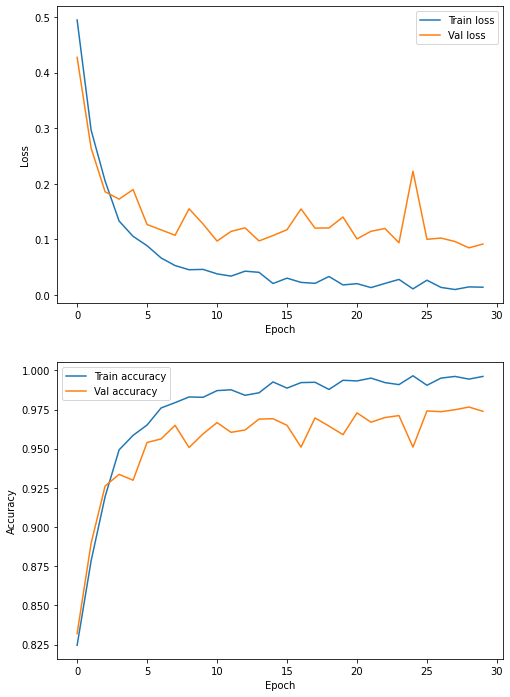

In [ ]:
# visualize history
import matplotlib.pyplot as plt

def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(8,12))

    plt.subplot(2,1,1)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(hist['epoch'], hist['loss'],
            label='Train loss')
    plt.plot(hist['epoch'], hist['val_loss'],
               label = 'Val loss')
    plt.legend()

    plt.subplot(2,1,2)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(hist['epoch'], hist['accuracy'],
            label='Train accuracy')
    plt.plot(hist['epoch'], hist['val_accuracy'],
               label = 'Val accuracy')
    plt.legend()
plot_history(cnn_history)

### 모델 저장 및 로딩 

In [ ]:
# save model
#cnn.save("./models/basic_3D_cnn3.h5")

# model load하는 경우
cnn  = tf.keras.models.load_model("./models/basic_3D_cnn3.h5")

Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/tas

## Confusion Matrix
- X train을 통한 메트릭스
- X test를 통한 메트릭스

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [ ]:
def output_class(x):
    output = np.argmax(x)
    if output == 0:
        return 'non-ROI'
    elif output == 1:
        return 'metastasis'
    elif output == 2:
        #print(x)
        return 'HCC'
    elif output == 3:
        return 'cholangiocarcinoma'

In [ ]:
# X_train을 통한 예측값 비교
y_pred = cnn.predict(X_i_tr)
y_true=pd.DataFrame(Y_tr_cat).apply(lambda x:output_class(x),axis=1)
y_pred_classified = pd.DataFrame(y_pred).apply(lambda x: output_class(x),axis=1)
print(confusion_matrix(y_true, y_pred_classified))

from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred_classified))

Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing o

In [ ]:
# X test 를 이용한 Y 값 예측    
y_pred = cnn.predict(X_i_te)    
y_true=pd.DataFrame(Y_te_cat).apply(lambda x:output_class(x),axis=1)
y_pred_classified = pd.DataFrame(y_pred).apply(lambda x: output_class(x),axis=1)
print(confusion_matrix(y_true, y_pred_classified))

from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred_classified))

Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ConcatV2 in device /job:localhost/replica:0/task:0/device:GPU:0
[[ 213    0    0   24]
 [   0  141    0    8]
 [   0    0  396   19]
 [   1    3   18 3200]]
          

## CAM

In [ ]:
print(cnn.predict(X_i_tr)[0])

Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
[9.999684e-01 3.086266e-05 6.874189e-07 7.025735e-08]


In [ ]:
y_pred = cnn.predict(X_i_te)

Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0


In [ ]:
output = np.argmax(y_pred[0])

In [ ]:
output

0

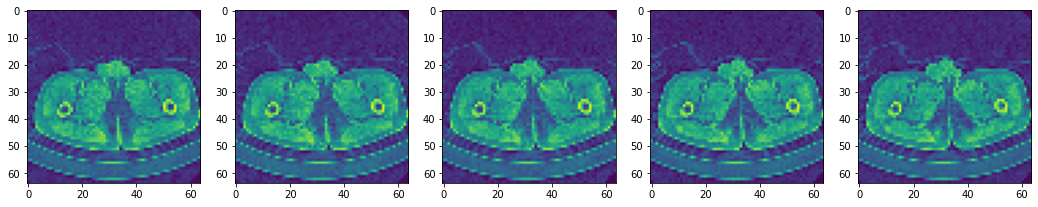

In [ ]:
f, ax = plt.subplots(1,5,figsize=(18,8)) 

for i in range(5): 
    X_i_tr[0][:,:,i].shape
    img = X_i_tr[0][:,:,i]
    img = np.expand_dims(img, axis=2)
    #img = np.repeat(img[:, :, np.newaxis], 3, axis=2)  # 2차원 배열을 3차원으로 3번 복사 
    img.shape
    
    ax[i].imshow(img)

In [ ]:
def resize_image_with_crop_or_pad(image, img_size=(64, 64, 5), **kwargs):
    """Image resizing. Resizes image by cropping or padding dimension
     to fit specified size.
    Args:
        image (np.ndarray): image to be resized
        img_size (list or tuple): new image size
        kwargs (): additional arguments to be passed to np.pad
    Returns:
        np.ndarray: resized image
    """

    assert isinstance(image, (np.ndarray, np.generic))
    assert (image.ndim - 1 == len(img_size) or image.ndim == len(img_size)), \
        'Example size doesnt fit image size'

    # Get the image dimensionality
    rank = len(img_size)

    # Create placeholders for the new shape
    from_indices = [[0, image.shape[dim]] for dim in range(rank)]
    to_padding = [[0, 0] for dim in range(rank)]

    slicer = [slice(None)] * rank

    # For each dimensions find whether it is supposed to be cropped or padded
    for i in range(rank):
        if image.shape[i] < img_size[i]:
            to_padding[i][0] = (img_size[i] - image.shape[i]) // 2
            to_padding[i][1] = img_size[i] - image.shape[i] - to_padding[i][0]
        else:
            from_indices[i][0] = int(np.floor((image.shape[i] - img_size[i]) / 2.))
            from_indices[i][1] = from_indices[i][0] + img_size[i]

        # Create slicer object to crop or leave each dimension
        slicer[i] = slice(from_indices[i][0], from_indices[i][1])

    # Pad the cropped image to extend the missing dimension
    return np.pad(image[slicer], to_padding, **kwargs)

In [ ]:
import SimpleITK as sitk
image_number = 110
image = X_i_te[image_number]
output = cnn.predict(np.expand_dims(image,0))
CLASS_INDEX= np.argmax(output)  #Index of class 
print(CLASS_INDEX)

model = tf.keras.models.load_model("./models/basic_3D_cnn3.h5")  #Trained Model
LAYER_NAME = 'conv3d_3'

resized_img=resize_image_with_crop_or_pad(image=image,img_size=(64,64,5),mode='symmetric')
io_img=tf.expand_dims(resized_img, axis=-1)
#print(io_img.shape)
io_img=tf.expand_dims(io_img, axis=0)
#print(io_img.shape)

# Create a graph that outputs target convolution and output
grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(LAYER_NAME).output, model.output])

###--Compute GRADIENT
with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(io_img)
    loss = predictions[:, CLASS_INDEX]

# Extract filters and gradients
output = conv_outputs[0]
grads = tape.gradient(loss, conv_outputs)[0]

Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
0


<ipython-input-9-ce178b320778>:38: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.pad(image[slicer], to_padding, **kwargs)


In [ ]:
# Average gradients spatially
weights = tf.reduce_mean(grads, axis=(0, 1,2))
# Build a ponderated map of filters according to gradients importance
cam = np.zeros(output.shape[0:3], dtype=np.float32)

for index, w in enumerate(weights):
    cam += w * output[:, :, :, index]
    
#cam.shape, weights.shape, output[:, :, :, 0].shape

In [ ]:
resized_img.shape

(64, 64, 5)

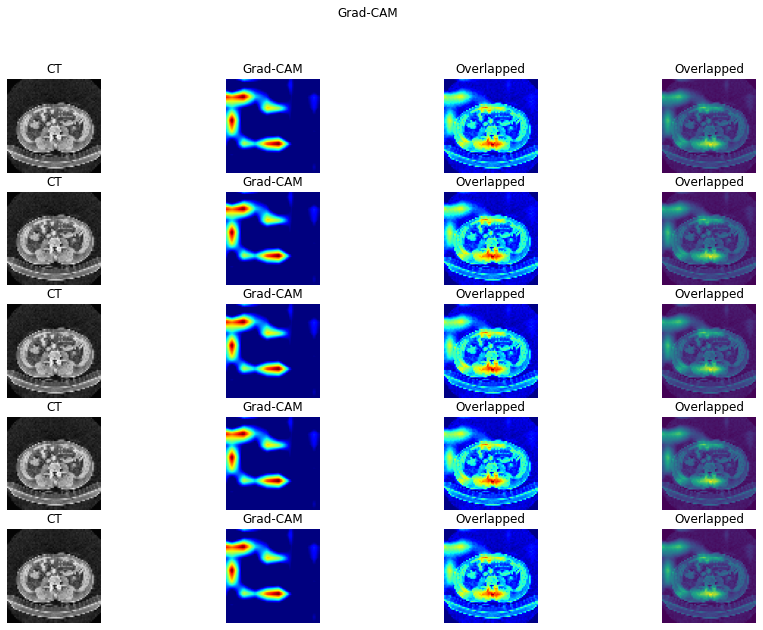

In [ ]:
from skimage.transform import resize
from matplotlib import pyplot as plt
capi=resize(cam,(64,64,5))
#print(capi.shape)
capi = np.maximum(capi,0)
heatmap = (capi - capi.min()) / (capi.max() - capi.min())

f, axarr = plt.subplots(5,4,figsize=(15,10));
f.suptitle('Grad-CAM')
slice_count=63
slice_count2=63
for i in range(5):
    #axial_ct_img=np.squeeze(resized_img[slice_count, :,:])
    #axial_grad_cmap_img=np.squeeze(heatmap[slice_count,:, :])

    img_plot = axarr[i,0].imshow(resized_img[:,:,0], cmap='gray');
    axarr[i,0].axis('off')
    axarr[i,0].set_title('CT')


    img_plot = axarr[i,1].imshow(heatmap[:,:,0], cmap='jet');
    axarr[i,1].axis('off')
    axarr[i,1].set_title('Grad-CAM')

    result = resized_img[:,:,0] + heatmap[:,:,0]
    img_plot = axarr[i,2].imshow(result,cmap='jet');
    axarr[i,2].axis('off')
    axarr[i,2].set_title('Overlapped')

    weighted=cv2.addWeighted(resized_img[:,:,0],1,heatmap[:,:,0], 1.5, 0,)
    img_plot = axarr[i,3].imshow(weighted);
    axarr[i,3].axis('off')
    axarr[i,3].set_title('Overlapped')
    


Found bbox (0, 1, 64, 64)
Found bbox (0, 0, 61, 62)
Found bbox (0, 1, 63, 64)
Found bbox (1, 0, 52, 64)
Found bbox (1, 9, 62, 63)
Found bbox (1, 10, 40, 64)
Found bbox (10, 9, 61, 63)
Found bbox (0, 0, 44, 64)
Found bbox (1, 10, 35, 64)
Found bbox (0, 10, 50, 63)
Found bbox (3, 17, 48, 63)
Found bbox (17, 1, 49, 44)
Found bbox (1, 11, 48, 63)
Found bbox (8, 0, 45, 63)
Found bbox (14, 10, 50, 62)
Found bbox (0, 19, 48, 63)
Found bbox (0, 18, 21, 44)
Found bbox (3, 10, 48, 63)
Found bbox (1, 3, 50, 62)
Found bbox (17, 14, 48, 61)
Found bbox (0, 3, 50, 45)
Found bbox (1, 9, 50, 62)
Found bbox (0, 1, 42, 62)
Found bbox (1, 12, 49, 62)
Found bbox (8, 0, 50, 62)
Found bbox (10, 22, 50, 33)
Found bbox (14, 0, 48, 61)
Found bbox (2, 13, 49, 62)
Found bbox (2, 18, 50, 61)
Found bbox (11, 9, 47, 62)
Found bbox (0, 2, 50, 45)
Found bbox (0, 0, 50, 61)
Found bbox (11, 9, 46, 61)
Found bbox (3, 8, 47, 44)
Found bbox (10, 9, 47, 26)
Found bbox (1, 9, 34, 42)
Found bbox (13, 9, 45, 61)
Found bbox (8,

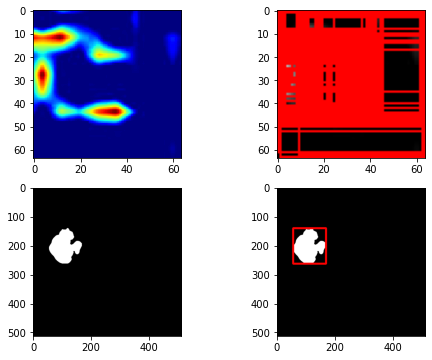

In [ ]:
from cv2 import imwrite
from skimage.measure import compare_ssim
from matplotlib.patches import Rectangle
from skimage.measure import label, regionprops
from PIL import Image

IMG_PATH = '../Diagnosis_Gallbladder_Cancer/benchmark_liver_tumor/raw/SN00017916/label/Tumor_0035.png'
img2 = heatmap[:,:,0]

f, ax = plt.subplots(2,2,figsize=(8,6));

img2 = np.expand_dims(img2, axis=2)
img = tf.keras.preprocessing.image.array_to_img(img2)
img.save('test.jpg')
img_test = cv2.imread('test.jpg')
ax[0,0].imshow(img_test[:,:,0], cmap='jet') # (64, 64, 1)
 
props = regionprops(img_test[:,:,0])

#cv2.rectangle(img_test, (props[10].bbox[1], props[10].bbox[0]), (props[10].bbox[3], props[10].bbox[2]), (255, 0, 0), 1)
for prop in props:
        print('Found bbox', prop.bbox)
        #print(prop.bbox[0],prop.bbox[1],prop.bbox[2],prop.bbox[3])
        cv2.rectangle(img_test, (prop.bbox[1], prop.bbox[0]), (prop.bbox[3], prop.bbox[2]), (255, 0, 0), 1)
        

ax[0,1].imshow(img_test,cmap='jet')

img_label = cv2.imread(IMG_PATH)
props_1 = regionprops(img_label[:,:,0])
ax[1,0].imshow(img_label)


for prop in props_1:
        print('Found bbox', prop.bbox)
        #print(prop.bbox[0],prop.bbox[1],prop.bbox[2],prop.bbox[3])
        cv2.rectangle(img_label, (prop.bbox[1], prop.bbox[0]), (prop.bbox[3], prop.bbox[2]), (255, 0, 0), 5)
        
ax[1,1].imshow(img_label,cmap='jet')
       

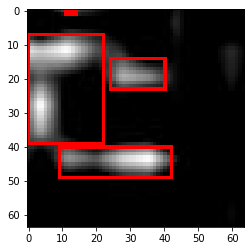

In [ ]:
img = heatmap[:,:,0]
#img = result
#img = weighted
img = np.expand_dims(img, axis=2)
img = tf.keras.preprocessing.image.array_to_img(img)
img.save('test.jpg')
img_test = cv2.imread('test.jpg')

gray = cv2.cvtColor(img_test, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

# Find contours
cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    x,y,w,h = cv2.boundingRect(c)
    cv2.rectangle(img_test, (x, y), (x + w, y + h), (255, 0, 0), 1)

#plt.imshow(thresh)
#weighted = np.expand_dims(weighted, axis=2)
#output = weighted + img_test
#weighted.shape, img_test.shape, output.shape
plt.imshow(img_test, cmap = 'jet')
#cv2.waitKey()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


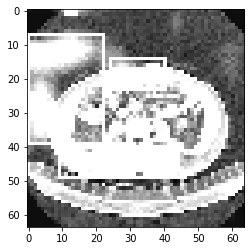

In [ ]:
#img_test.shape, weighted.shape # ((64, 64, 3), (64, 64))
weighted_3d = np.repeat(weighted[:, :, np.newaxis], 3, axis=2)
res = resized_img[:,:,0]
resized_img_3d =  np.repeat(res[:, :, np.newaxis], 3, axis=2)
resized_img_3d.shape, weighted_3d.shape

output = resized_img_3d+ weighted_3d
plt.imshow(output, cmap = 'gray')